
⏳ Prévision de Température (°C)...


16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] done processing


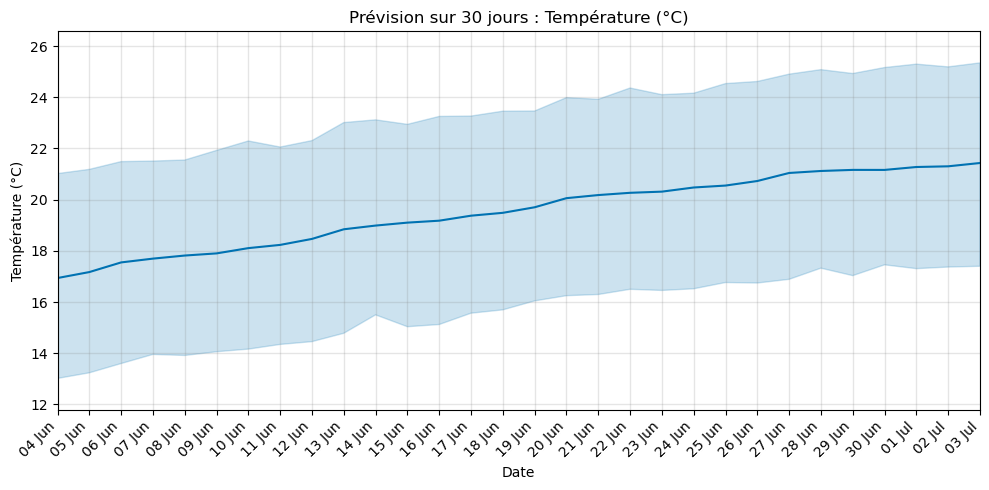


⏳ Prévision de Précipitations (mm)...


16:52:29 - cmdstanpy - INFO - Chain [1] start processing
16:53:08 - cmdstanpy - INFO - Chain [1] done processing


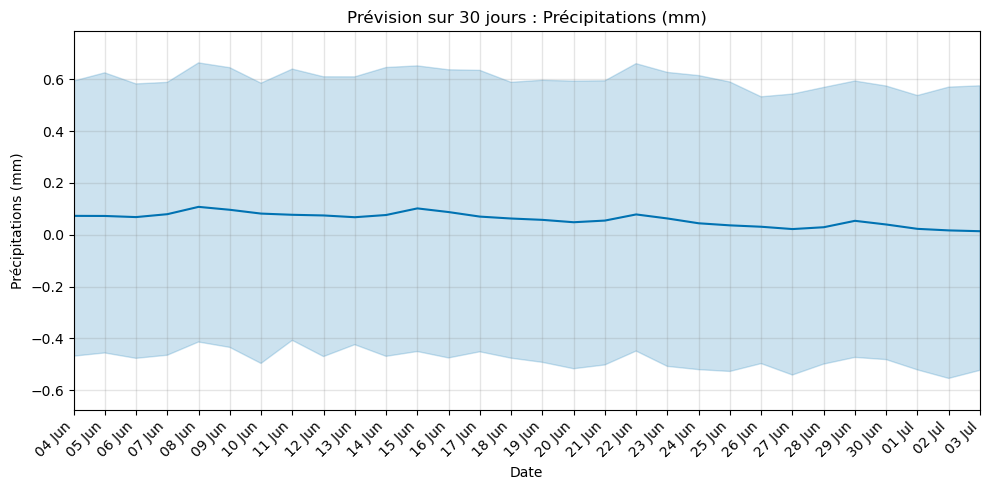


⏳ Prévision de Vitesse du vent (km/h)...


16:53:45 - cmdstanpy - INFO - Chain [1] start processing
16:54:45 - cmdstanpy - INFO - Chain [1] done processing


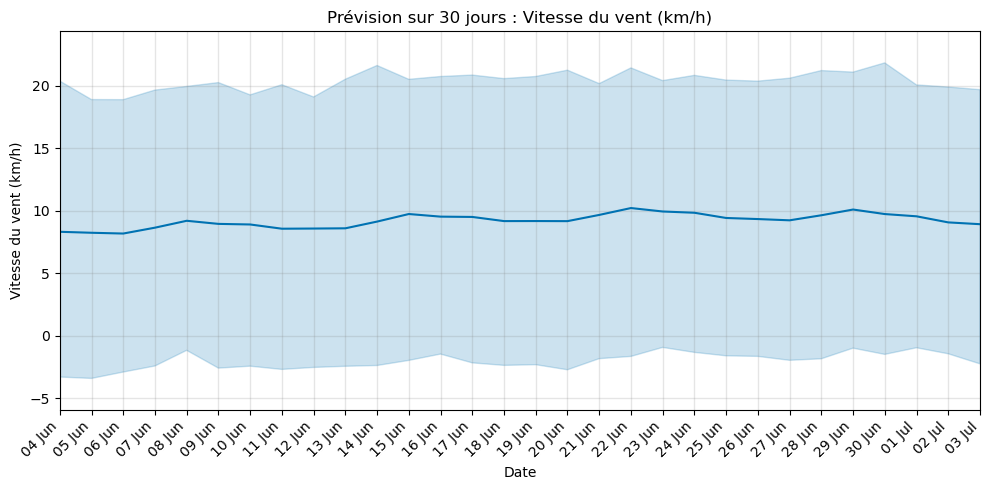

In [7]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

prophet_df = pd.read_csv("meteo_aix.csv")
prophet_df["date"] = pd.to_datetime(prophet_df["date"]).dt.tz_localize(None)

targets = {
    "Température (°C)": "temperature_2m",
    "Précipitations (mm)": "precipitation",
    "Vitesse du vent (km/h)": "wind_speed_10m"
}

for label, column in targets.items():
    print(f"\n⏳ Prévision de {label}...")
    
    df_prophet = prophet_df[["date", column]].rename(columns={"date": "ds", column: "y"})
    
    model = Prophet()
    model.fit(df_prophet)

    # Prédiction sur 30 jours
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    forecast_future = forecast[forecast["ds"] > df_prophet["ds"].max()]

    fig, ax = plt.subplots(figsize=(10, 5))
    model.plot(forecast, ax=ax)
    
    ax.set_xlim(forecast_future["ds"].min(), forecast_future["ds"].max())
    
    y_min = forecast_future["yhat_lower"].min()
    y_max = forecast_future["yhat_upper"].max()
    y_margin = (y_max - y_min) * 0.1  # marge de 10%
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    plt.title(f"Prévision sur 30 jours : {label}")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.tight_layout()
    plt.show()



In [10]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

prophet_df = pd.read_csv("meteo_aix.csv")
prophet_df["date"] = pd.to_datetime(prophet_df["date"]).dt.tz_localize(None)  # Enlever le timezone

targets = {
    "Température (°C)": "temperature_2m",
    "Précipitations (mm)": "precipitation",
    "Vitesse du vent (km/h)": "wind_speed_10m"
}

test_ratio = 0.1

for label, column in targets.items():
    print(f"\n🔍 Évaluation du modèle pour {label}...")

    df_prophet = prophet_df[["date", column]].rename(columns={"date": "ds", column: "y"}).copy()
    df_prophet.dropna(inplace=True)

    if len(df_prophet) < 10:
        print("⚠️ Pas assez de données pour évaluer.")
        continue

    horizon = max(1, int(len(df_prophet) * test_ratio))
    train_df = df_prophet[:-horizon]
    test_df = df_prophet[-horizon:]

    model = Prophet()
    model.fit(train_df)

    future = model.make_future_dataframe(periods=horizon)
    forecast = model.predict(future)

    forecast_test = forecast[['ds', 'yhat']]
    merged = pd.merge(test_df, forecast_test, on='ds', how='inner')

    if len(merged) < 1:
        print("⚠️ Aucune correspondance de dates entre prédiction et test.")
        continue

    y_true = merged['y'].values
    y_pred = merged['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"📊 MAE  : {mae:.2f}")
    print(f"📊 RMSE : {rmse:.2f}")



🔍 Évaluation du modèle pour Température (°C)...


23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:25 - cmdstanpy - INFO - Chain [1] done processing


📊 MAE  : 2.38
📊 RMSE : 3.01

🔍 Évaluation du modèle pour Précipitations (mm)...


23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:33:41 - cmdstanpy - INFO - Chain [1] done processing


📊 MAE  : 0.14
📊 RMSE : 0.49

🔍 Évaluation du modèle pour Vitesse du vent (km/h)...


23:34:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:10 - cmdstanpy - INFO - Chain [1] done processing


📊 MAE  : 6.39
📊 RMSE : 7.90
